In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

hexagons = gpd.read_file('../data/shapefiles/nyc/hexagons.geojson')

nynta = gpd.read_file('../data/shapefiles/nyc/nta_map.geojson')
nynta = nynta.to_crs(epsg=3627)                        # project to NAD83

# nybb = gpd.read_file(gpd.datasets.get_path('nybb'))  # import NY boro bounds
# nybb = nybb.to_crs(epsg=3627)                        # project to NAD83

In [2]:
night = gpd.read_file('../data/landscan/polygon_extracts/nyc_night_pop.shp')
day = gpd.read_file('../data/landscan/polygon_extracts/nyc_day_pop.shp')

night.rename(columns={'gridcode': 'night_pop'}, inplace=True) # rename population column
keep_cols = ['OBJECTID','night_pop', 'geometry']              # select columns for filtering
night = night[keep_cols]                                      # filter columns
night = night.to_crs(epsg=3627)                               # project to NAD83

day.rename(columns={'gridcode': 'day_pop'}, inplace=True)     # rename population column
keep_cols = ['OBJECTID','day_pop', 'geometry']                # select columns for filtering
day = day[keep_cols]                                          # filter columns
day = day.to_crs(epsg=3627)                                   # project to NAD83

#### MERGING ISSUE: DIFFERENT OBJECT IDs in DAY // NIGHT FILES

Solution: Aggregate each up to hexbins individually, then merge.

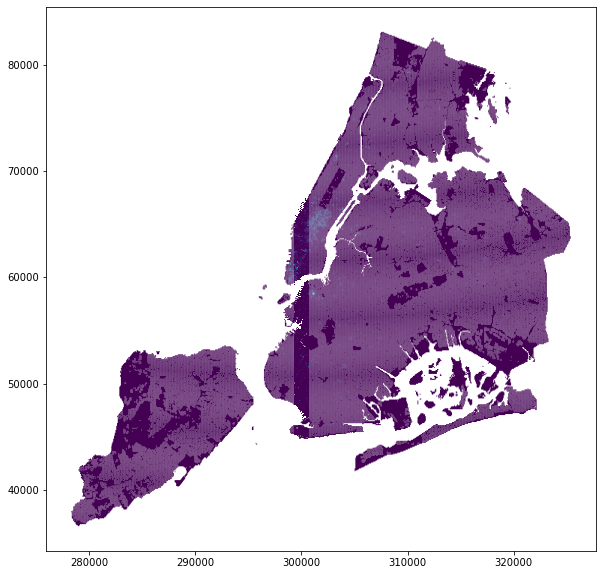

In [3]:
day.plot(column='day_pop',
        figsize=(10,10));

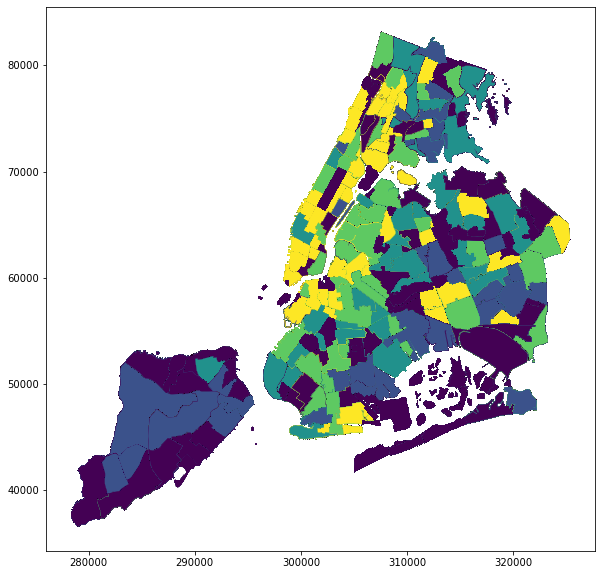

In [4]:
ntas_day = gpd.sjoin(nynta, day, how="inner")

ntas_day.plot(column='day_pop',
               scheme='quantiles',
               figsize=(10,10));

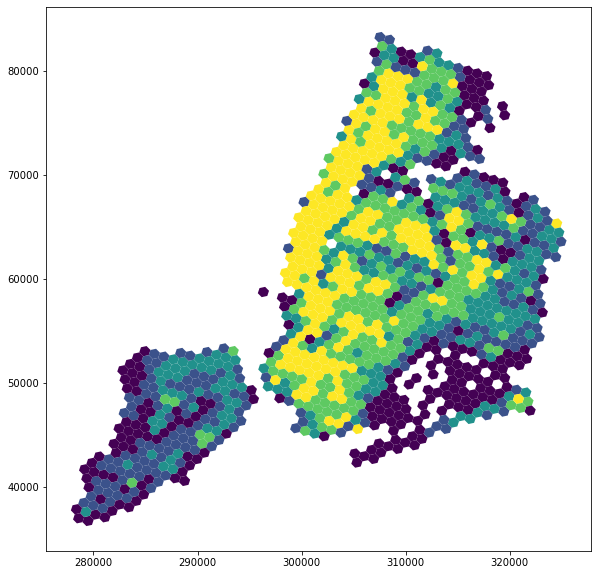

In [5]:
hexes_by_day = gpd.sjoin(hexagons, day, how="inner")

keep_cols = ['hex_id_8', 'day_pop', 'geometry']
day_hexes = hexes_by_day[keep_cols].dissolve(by='hex_id_8',
                                          aggfunc='sum')

day_hexes.plot(column='day_pop',
               scheme='quantiles',
               figsize=(10,10));

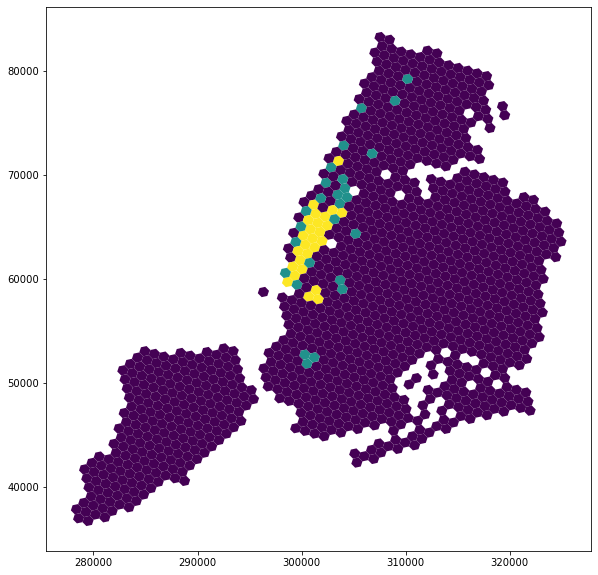

In [6]:
hexes_by_day = gpd.sjoin(hexagons, day, how="inner")

keep_cols = ['hex_id_8', 'day_pop', 'geometry']
day_hexes = hexes_by_day[keep_cols].dissolve(by='hex_id_8',
                                          aggfunc='sum')

day_hexes.plot(column='day_pop',
               scheme='StdMean',
               figsize=(10,10));

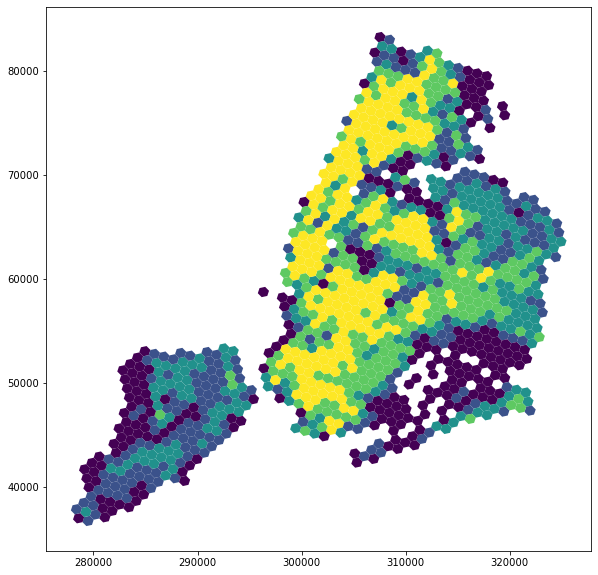

In [7]:
hexes_by_night = gpd.sjoin(hexagons, night, how="inner")

keep_cols = ['hex_id_8', 'night_pop', 'geometry']
night_hexes = hexes_by_night[keep_cols].dissolve(by='hex_id_8',
                                                 aggfunc='sum')

night_hexes.plot(column='night_pop',
                 scheme='quantiles',
                 figsize=(10,10));

In [50]:
sel_cols = ['hex_id_8', 'day_pop']
day_pop = day_hexes.reset_index()[sel_cols]

sel_cols = ['hex_id_8', 'night_pop']
night_pop = night_hexes.reset_index()[sel_cols]

pop_hexes = hexagons.merge(day_pop.merge(night_pop))

pop_hexes['night_day_delta'] = pop_hexes['night_pop'] - pop_hexes['day_pop']
pop_hexes['day_night_delta'] = pop_hexes['day_pop'] - pop_hexes['night_pop']

pop_hexes.head(3)

,hex_id_8,geometry,day_pop,night_pop,night_day_delta,day_night_delta
0,882a100f47fffff,"POLYGON ((309177.150 70241.423, 308638.240 701...",5304,4581,-723,723
1,882a100f43fffff,"POLYGON ((309756.428 68989.222, 310295.305 691...",10200,8570,-1630,1630
2,882a100f55fffff,"POLYGON ((309756.428 68989.222, 309590.261 684...",626,550,-76,76


In [52]:
print(f"There are {pop_hexes[pop_hexes['day_night_delta'] > 0].shape[0]} hexbins with greater day-time populations.")
print(f"There are {pop_hexes[pop_hexes['day_night_delta'] < 0].shape[0]} hexbins with greater night-time populations.")

There are 393 hexbins with greater day-time populations.
There are 746 hexbins with greater night-time populations.


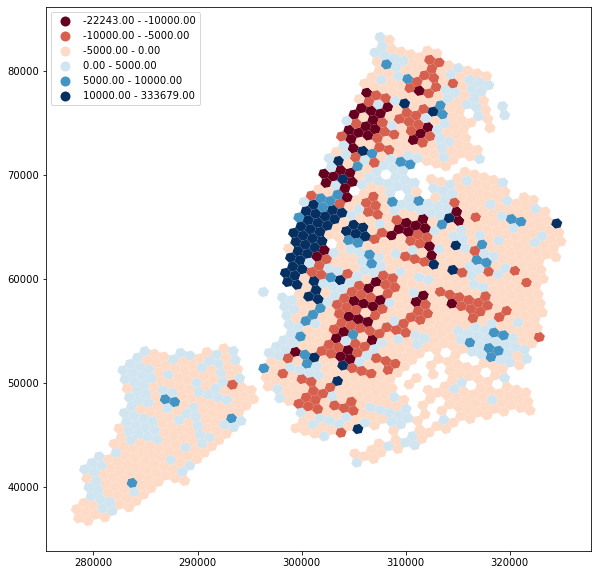

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

pop_hexes.plot(column='day_night_delta',
         ax=ax,
         cmap='RdBu',
         scheme='userdefined',                                          # USER DEFINED BINNING SCHEME
         classification_kwds={'bins':[-10000, -5000, 0, 5000, 10000]},  # USER DEFINED BINNING SCHEME
         legend=True,
         legend_kwds={'loc': 'upper left'});

#### Fig. 1: Blue areas lose population at night-time, while red areas gain population. (Note: user defined binning scheme)

In [54]:
print(f"The data shows {pop_hexes['day_pop'].sum()} people in NYC during the day.")
print(f"The data shows {pop_hexes['night_pop'].sum()} people in NYC during the night.")

The data shows 11273916 people in NYC during the day.
The data shows 10256243 people in NYC during the night.


In [55]:
pop_hexes.to_file("../data/shapefiles/nyc/population_hexbinned.geojson",
                  driver='GeoJSON')